In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
direccion='../limpiezacolumnas/salida/'

In [5]:
dd=pd.DataFrame()
for path, subdirs, files in os.walk(direccion):
        for name in tqdm(files):
             if(len(name)<8):
                print(name)
            
                df=pd.read_csv(os.path.join(path, name))
                df["Hora"]=pd.to_datetime(df["Hora"],dayfirst=True)
                df = df.set_index('Hora')
                ix=df.index.values-3
                imputer = KNNImputer(n_neighbors=6)
                df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
                df['index']=ix
                dff = df.set_index('index')
                df=pd.melt(df, id_vars=['index'], var_name='NIS', value_name='KWh')
                df["cat"]=name[:3]
                
                dd = pd.concat([dd, df],axis=0)
                  #df["Hora"] 

 50%|█████     | 3/6 [00:00<00:00, 20.83it/s]

141.csv
142.csv
245.csv
343.csv
546.csv


100%|██████████| 1/1 [00:00<?, ?it/s]

846.csv


In [6]:
df.head()

index      NIS    KWh  cat
0 2021-12-01 00:59:59.999999997  2560681  1.832  846
1 2021-12-01 01:59:59.999999997  2560681  1.656  846
2 2021-12-01 02:59:59.999999997  2560681  1.588  846
3 2021-12-01 03:59:59.999999997  2560681  2.060  846
4 2021-12-01 04:59:59.999999997  2560681  2.336  846

In [7]:

dd['hour'] = dd['index'].apply(lambda x: x.hour)

In [8]:
dd['day'] = dd['index'].apply(lambda x: x.dayofweek)

In [9]:
dd.head()

index      NIS    KWh  cat  hour  day
0 2021-12-01 00:59:59.999999997  1572256  0.052  141     0    2
1 2021-12-01 01:59:59.999999997  1572256  0.046  141     1    2
2 2021-12-01 02:59:59.999999997  1572256  0.042  141     2    2
3 2021-12-01 03:59:59.999999997  1572256  0.044  141     3    2
4 2021-12-01 04:59:59.999999997  1572256  0.052  141     4    2

In [10]:
dd['max_KWh'] = dd.groupby(['cat'])['KWh'].transform(max)

In [11]:
dd['norm_KWh'] = dd['KWh'] / dd['max_KWh']

In [12]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None,fig=None,ax=None):
    if(fig==None and ax==None):
        fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

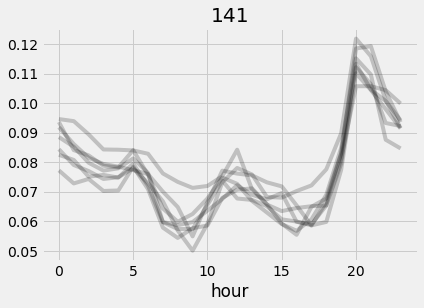

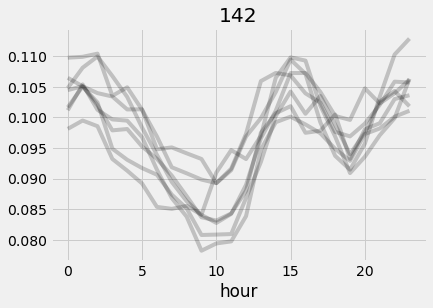

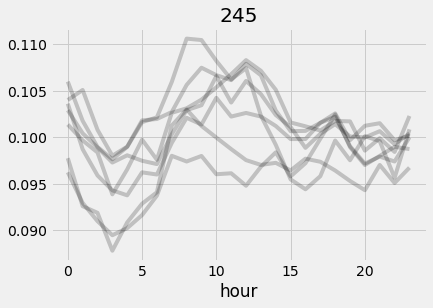

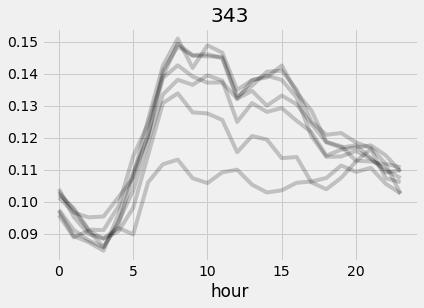

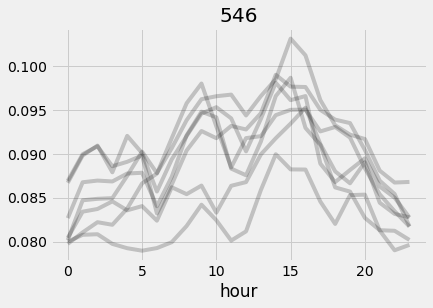

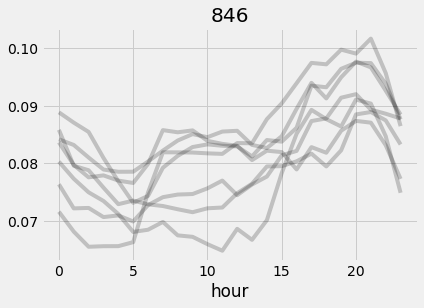

In [13]:
for cat in np.unique(dd.cat):
    multiline_hourly_plot(dd[dd.cat == cat].groupby('day'),ycol = 'norm_KWh',opacity =0.2,title=cat)

In [14]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

In [16]:
red_df = dd[['cat','NIS',  'day', 'hour', 'norm_KWh']]


In [17]:
piv_df =pd.pivot_table(red_df, index = ['cat','NIS'], columns = ['hour','day'], values = 'norm_KWh') #pd.pivot_table(red_df, index = ['cat','NIS',  'day'], columns = 'hour', values = 'norm_KWh')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['cat']).mean()
grp_df.reset_index(inplace = True)
#del grp_df['day'] # This feature is not relevant any more

D:\UserFiles\anaconda\envs\ia\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [26]:
grp_df.head()

hour  cat         0                                                    \
day               0         1         2         3         4         5   
0     141  0.093583  0.077231  0.082502  0.088509  0.084395  0.091818   
1     142  0.109769  0.104469  0.101669  0.101179  0.098138  0.104818   
2     245  0.102921  0.105996  0.103623  0.097768  0.096247  0.101380   
3     343  0.095745  0.097017  0.097426  0.102257  0.101295  0.103967   
4     546  0.079756  0.080444  0.080009  0.082687  0.080176  0.086706   

hour                   1                                                    \
day          6         0         1         2         3         4         5   
0     0.094594  0.084095  0.072824  0.080772  0.085205  0.079055  0.086138   
1     0.106476  0.109910  0.105120  0.105053  0.105401  0.099502  0.108130   
2     0.104015  0.100441  0.101785  0.098730  0.092607  0.092959  0.099674   
3     0.103058  0.088796  0.089211  0.091099  0.097899  0.096539  0.095204   
4     0.086933  0.081058  0.083421  0.080785  0.086768  0.084715  0.089816   

hour                   2                                                    \
day          6         0         1         2         3         4         5   
0     0.093899  0.082308  0.074336  0.075110  0.079823  0.077008  0.081513   
1     0.105096  0.110427  0.102022  0.102453  0.101249  0.098576  0.109968   
2     0.105096  0.098915  0.098975  0.095911  0.091893  0.090997  0.098385   
3     0.097353  0.090896  0.087289  0.087861  0.091242  0.095052  0.089832   
4     0.089967  0.082221  0.083726  0.080852  0.086961  0.084884  0.090946   

hour                   3                                                    \
day          6         0         1         2         3         4         5   
0     0.089431  0.078800  0.070273  0.075699  0.077157  0.074334  0.079396   
1     0.103983  0.103536  0.097895  0.094898  0.099683  0.093224  0.106773   
2     0.100818  0.097297  0.097648  0.094309  0.087822  0.089485  0.093882   
3     0.090850  0.085851  0.084618  0.085647  0.091027  0.095313  0.088352   
4     0.090867  0.081928  0.084593  0.079753  0.086860  0.084961  0.087905   

hour                   4                                                    \
day          6         0         1         2         3         4         5   
0     0.084315  0.078230  0.070445  0.074790  0.077945  0.074922  0.078498   
1     0.103426  0.104926  0.098113  0.093088  0.099481  0.091308  0.103356   
2     0.098028  0.098076  0.098982  0.093773  0.090862  0.090249  0.096563   
3     0.088481  0.092779  0.095869  0.093584  0.098426  0.101303  0.090675   
4     0.088595  0.083774  0.083573  0.079260  0.087764  0.087503  0.092053   

hour                   5                                                    \
day          6         0         1         2         3         4         5   
0     0.084223  0.084077  0.078472  0.079524  0.081275  0.077926  0.077336   
1     0.101314  0.101258  0.095263  0.091735  0.096789  0.089215  0.098350   
2     0.099005  0.097490  0.101634  0.096243  0.092873  0.091650  0.099755   
3     0.091742  0.107980  0.109090  0.103414  0.114151  0.107419  0.098026   
4     0.089099  0.086639  0.084055  0.078976  0.087850  0.090257  0.090091   

hour                   6                                                    \
day          6         0         1         2         3         4         5   
0     0.083986  0.075737  0.070891  0.072050  0.076370  0.072940  0.075977   
1     0.101333  0.096895  0.093241  0.090644  0.091473  0.085390  0.093896   
2     0.101826  0.097131  0.102156  0.096009  0.094100  0.093743  0.097596   
3     0.089734  0.125549  0.120344  0.118514  0.124267  0.120863  0.114521   
4     0.089820  0.087753  0.082395  0.079274  0.084043  0.087810  0.085717   

hour                   7                                                    \
day          6         0         1         2         3         4         5   
0     0.082866  0.064355  0.057872  0.059756  0.05

In [19]:
kmeans_df = grp_df#pd.get_dummies(grp_df, columns =['cat','NIS'])

In [29]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    print(k_mean_algs)
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

In [32]:
k_algs, k_res = elbow_method(kmeans_df.drop(['cat'], axis = 1), 2, 10)

D:\UserFiles\anaconda\envs\ia\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10)]


D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

ValueError: n_samples=6 should be >= n_clusters=7.

In [ ]:
algorithm = k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[4]

In [ ]:
clustering.cluster_centers_

In [78]:
cls_list = algorithm.predict(kmeans_df.drop(['cat', 'NIS'], axis = 1))

D:\UserFiles\anaconda\envs\ia\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [79]:
kmeans_df['cluster'] = cls_list

In [80]:
def print_building_types_in_clusters(data):
    for tp in data['cat'].unique():
        print('How many cat of type', tp, 'are in each cluster?')
        print(data[data.cat == tp]['cluster'].value_counts())

In [81]:
print_building_types_in_clusters(kmeans_df)

How many cat of type 141 are in each cluster?
2    19
0    17
5     6
4     3
Name: cluster, dtype: int64
How many cat of type 142 are in each cluster?
0    36
2    32
5    19
4    18
1     6
Name: cluster, dtype: int64
How many cat of type 245 are in each cluster?
0    53
2    22
1    12
4    10
5     8
3     2
Name: cluster, dtype: int64
How many cat of type 343 are in each cluster?
0    25
2    14
4    12
1     8
5     6
3     2
Name: cluster, dtype: int64
How many cat of type 546 are in each cluster?
0    42
2    21
4    11
1     8
5     6
3     1
Name: cluster, dtype: int64
How many cat of type 846 are in each cluster?
0    24
2    12
4     2
1     2
3     2
5     1
Name: cluster, dtype: int64


In [82]:
def make_cluster_table(data):
    tbl = data[['cat', 'cluster']]
    tbl_grp = tbl.groupby(tbl.columns.tolist(), as_index = False).size()
    tbl_frm = tbl_grp#.reset_index().drop('index')
    
    tbl_frm.columns = ['cat', 'cluster','count']
    tbl_pvt = pd.pivot_table(tbl_frm, index = 'cat', columns = 'cluster', values = 'count').fillna(0).astype(int)
    return (tbl_frm, tbl_pvt)

In [83]:
tbl_frm, tbl_pvt = make_cluster_table(kmeans_df)
tbl_pvt

cluster   0   1   2  3   4   5
cat                           
141      17   0  19  0   3   6
142      36   6  32  0  18  19
245      53  12  22  2  10   8
343      25   8  14  2  12   6
546      42   8  21  1  11   6
846      24   2  12  2   2   1

In [84]:


from matplotlib.ticker import MaxNLocator

def cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['count'])
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq)
    plt.show()



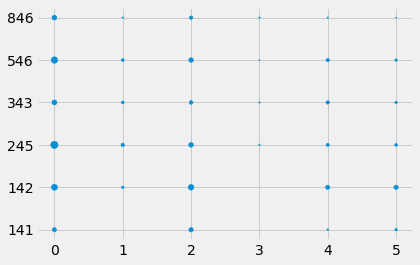

In [85]:
cluster_scatter_plot(tbl_frm)

In [86]:
 tbl_frm.head()

cat  cluster  count
0  141        0     17
1  141        2     19
2  141        4      3
3  141        5      6
4  142        0     36

In [87]:
def compute_building_share(original_df, kmeans_df, tbl_frm):
    bld_share = {}
    for tp in original_df['cat'].unique():
        tot_num_buildings = len(original_df[original_df.cat == tp].groupby('NIS'))
        bld_share[tp] = {}
        for c in kmeans_df['cluster'].unique():
            nb = tbl_frm[(tbl_frm.cat == tp) & (tbl_frm.cluster == c)]['count']
            if not nb.empty:
                bld_share[tp][c] = int(nb) / tot_num_buildings
    return bld_share

In [88]:
bld_share = compute_building_share(dd, kmeans_df, tbl_frm)
tbl_frm['bld_pct'] = tbl_frm.apply(lambda row: bld_share[row['cat']][row['cluster']], axis = 1)

In [89]:
def norm_cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['bld_pct'].apply(lambda x: x * 100))
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq);

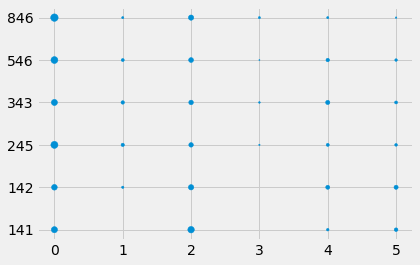

In [90]:
norm_cluster_scatter_plot(tbl_frm)

In [91]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

hour  cat      NIS  cluster day         0         1         2         3  \
0     141  1007512        0   0  0.095722  0.096586  0.099179  0.098963   
1     141  1007512        0   1  0.070441  0.071089  0.081245  0.083621   
2     141  1007512        0   2  0.076232  0.076577  0.076923  0.077615   
3     141  1007512        0   3  0.082455  0.082973  0.084702  0.085220   
4     141  1007512        0   4  0.065514  0.067243  0.063613  0.064650   
...   ...      ...      ...  ..       ...       ...       ...       ...   
3229  846  2833495        2   2  0.055714  0.055621  0.054610  0.053642   
3230  846  2833495        2   3  0.058261  0.058558  0.057285  0.053761   
3231  846  2833495        2   4  0.054958  0.052725  0.051774  0.061335   
3232  846  2833495        2   5  0.047132  0.046963  0.047016  0.045169   
3233  846  2833495        2   6  0.047950  0.048990  0.049106  0.047525   

hour         4         5         6         7         8         9        10  \
0     0.086214  0.066335  0.027874  0.003889  0.003025  0.003241  0.002377   
1     0.090320  0.051426  0.005618  0.003025  0.002809  0.002593  0.001513   
2     0.078133  0.077787  0.032325  0.002074  0.000864  0.001037  0.001037   
3     0.079516  0.058600  0.012965  0.001037  0.000519  0.000691  0.000864   
4     0.067761  0.063613  0.015557  0.000691  0.000691  0.001210  0.001037   
...        ...       ...       ...       ...       ...       ...       ...   
3229  0.058864  0.081151  0.099907  0.117295  0.088232  0.077772  0.073985   
3230  0.054135  0.080608  0.116777  0.107752  0.101494  0.085677  0.071922   
3231  0.070793  0.095712  0.109153  0.109000  0.100119  0.078434  0.067635   
3232  0.043046  0.051738  0.066628  0.073983  0.079704  0.058923  0.049945   
3233  0.044118  0.042261  0.038143  0.043609  0.047705  0.043768  0.044553   

hour        11        12        13        14        15        16        17  \
0     0.007131  0.005618  0.004538  0.002161  0.001513  0.001152  0.001296   
1     0.002593  0.004970  0.002809  0.001945  0.001945  0.002161  0.001945   
2     0.001901  0.001729  0.001901  0.000864  0.001037  0.001037  0.001037   
3     0.001210  0.001037  0.000864  0.001037  0.000691  0.000691  0.007087   
4     0.001037  0.001037  0.001037  0.001556  0.000691  0.000691  0.000691   
...        ...       ...       ...       ...       ...       ...       ...   
3229  0.093794  0.095882  0.110995  0.119910  0.111572  0.093963  0.075217   
3230  0.072287  0.071676  0.081015  0.084853  0.094303  0.096256  0.102717   
3231  0.085116  0.098591  0.106707  0.089039  0.087570  0.077976  0.065223   
3232  0.043450  0.048968  0.048735  0.046909  0.050741  0.045042  0.049966   
3233  0.052598  0.051696  0.052927  0.051643  0.044171  0.047196  0.051335   

hour        18        19        20        21        22        23  
0     0.001296  0.005618  0.019447  0.023336  0.064607  0.068928  
1     0.005402  0.011236  0.023984  0.041919  0.061150  0.069793  
2     0.001037  0.021262  0.047018  0.061020  0.076059  0.082455  
3     0.013656  0.023682  0.040104  0.040277  0.042178  0.058773  
4     0.000864  0.016768  0.035782  0.048574  0.083146  0.095506  
...        ...       ...       ...       ...       ...       ...  
3229  0.065020  0.070929  0.068730  0.064187  0.062320  0.059475  
3230  0.078222  0.067669  0.057200  0.059042  0.055604  0.055060  
3231  0.068263  0.072185  0.059976  0.054738  0.053405  0.047748  
3232  0.053383  0.064463  0.063084  0.051898  0.049043  0.049552  
3233  0.065578  0.068602  0.059030  0.058690  0.066607  0.064877  

[3234 rows x 28 columns]

In [210]:
def clusters_visualisation(kmeans_df, id_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars =kmeans_df.columns, var_name = ['hour'], value_name = 'norm_KWh')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_KWh', opacity = 0.1, title = 'Cluster ' + str(c))

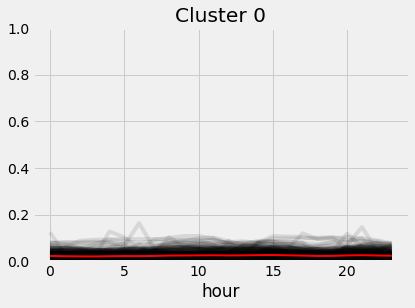

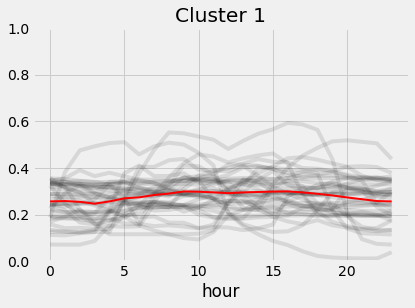

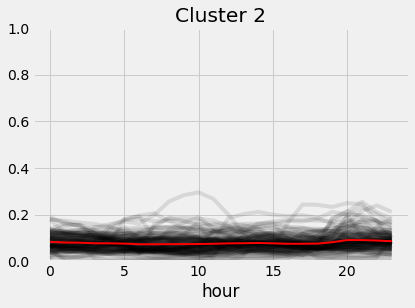

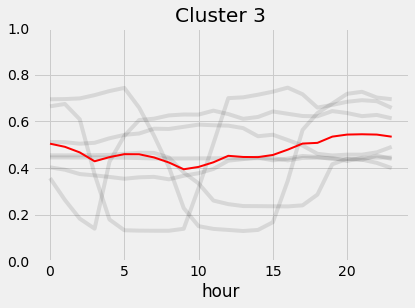

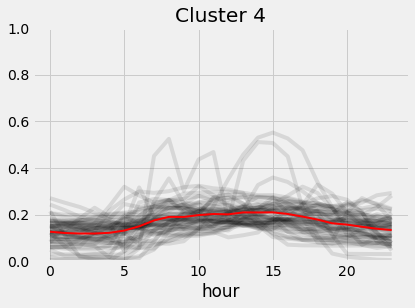

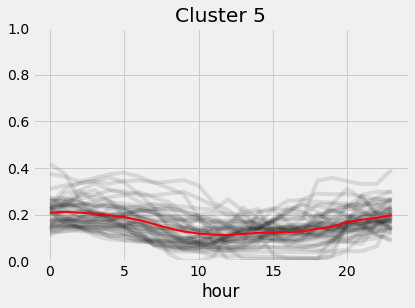

In [211]:
ddd=kmeans_df.set_index(['cat','NIS','cluster']).stack(level=1).reset_index().groupby(['cat','NIS','cluster']).mean().reset_index()
clusters_visualisation(ddd, id_vars = ['cat', 'NIS', 'cluster'])